# Feature Engineering & Feature Selection
We have incorporated a set of supplemental features from an external source, `supplemental-stats.csv`. Typically, feature engineering would involve manually crafting features from raw data. For instance, raw counts of a pitcher’s total strikes (both swinging and looking) could be used to generate features such as `'L/Str'` (looking strike percentage, calculated as strikes looking / total strikes) and `'S/Str'` (swinging strike percentage, calculated as swinging strikes without contact / total strikes).

However, given that our dataset is already quite robust after integrating the supplemental data adn that it contains a number of these features already, we will focus on preparing these features for model training and selecting the most predictive features for model performance.

--- 
## Development Workflow

All functions demonstrated in this notebook are defined in the `bullpen.data_utils` module for clarity, reusability, and unit testing. While this notebook retains the initial development and intent of these functions, their inclusion here is primarily for transparency and ease of reference.  

For production usage, refer to the source code in the `bullpen.data_utils` module.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(display="text")

from bullpen import data_utils

## Feature Engineering
Time permitting, spend more time here.

In [2]:
train = pd.read_csv(data_utils.DATA_DIR.joinpath("train.csv"))
train

,PlayerId,Team,Season,MLBAMID,Name,Age,TBF,K%,Rk,IP,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,18655,ATL,2021,621345,A.J. Minter,27,221,0.257919,696,52.1,...,44,7,11,46,0.193,11,4,0,0,0
1,18655,ATL,2022,621345,A.J. Minter,28,271,0.346863,649,70.0,...,50,2,23,71,0.245,12,0,0,0,0
2,18655,ATL,2023,621345,A.J. Minter,29,260,0.315385,647,64.2,...,40,4,13,69,0.159,8,1,0,0,0
3,19343,OAK,2022,640462,A.J. Puk,27,281,0.270463,773,66.1,...,48,6,22,54,0.289,15,4,0,0,0
4,19343,MIA,2023,640462,A.J. Puk,28,242,0.322314,755,56.2,...,42,6,22,56,0.282,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,1943,HOU,2021,425844,Zack Greinke,37,697,0.172166,417,171.0,...,51,4,34,85,0.283,13,6,0,0,0
984,1943,KCR,2022,425844,Zack Greinke,38,585,0.124786,396,137.0,...,39,3,22,51,0.301,7,2,0,0,0
985,1943,KCR,2023,425844,Zack Greinke,39,593,0.163575,353,142.1,...,53,6,25,70,0.263,11,2,0,0,0
986,25918,STL,2022,668868,Zack Thompson,24,136,0.198529,967,34.2,...,40,3,10,17,0.370,3,2,0,0,0


In [3]:
train.Season.unique()

array([2021, 2022, 2023])

### Split training data into features and target
We will be dropping the `'Name'` column and keeping the `MLBAMID` and `PlayerId` columns for player identification.

In [4]:
target = "K%"
drop_cols = ["Name", "Rk", target]

X_df = train[[c for c in train.columns if c not in drop_cols]]
y_df = train[target]

In [5]:
X_df.head()

,PlayerId,Team,Season,MLBAMID,Age,TBF,IP,PA,Pit,Pit/PA,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,18655,ATL,2021,621345,27,221,52.1,221,876,3.96,...,44,7,11,46,0.193,11,4,0,0,0
1,18655,ATL,2022,621345,28,271,70.0,272,1111,4.08,...,50,2,23,71,0.245,12,0,0,0,0
2,18655,ATL,2023,621345,29,260,64.2,260,1062,4.08,...,40,4,13,69,0.159,8,1,0,0,0
3,19343,OAK,2022,640462,27,281,66.1,281,1072,3.81,...,48,6,22,54,0.289,15,4,0,0,0
4,19343,MIA,2023,640462,28,242,56.2,242,950,3.93,...,42,6,22,56,0.282,16,0,0,0,0


In [6]:
y_df.head()

0    0.257919
1    0.346863
2    0.315385
3    0.270463
4    0.322314
Name: K%, dtype: float64

All but one of our features are numeric. Since `'Team'` is a categorical variable, we will apply [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to it. This process will convert the `'Team'` column into 31 independent binary columns—one for each MLB team that appears in the column, plus an additional column for the `'- - -'` multiple team indicator. We will use `sklearn`'s `OneHotEncoder()` to perform this transformation.

The numeric features will be standardized using `sklearn`'s `StandardScaler()`. This technique removes the mean and scales the features to unit variance, ensuring that each feature contributes equally to the model.

For further details, refer to this guide: [Column Transformer with Mixed Types](https://scikit-learn.org/1.5/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py).

In [7]:
categorical_features = ["Team"]

categorical_transformer = Pipeline(
    steps=[
        # When an unknown category is encountered during transform,
        # the resulting one-hot encoded columns for this feature will be all zeros.
        # TL;DR Creates a new category for missing values.
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
categorical_transformer

Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [8]:
numeric_features = [f for f in X_df.columns if f not in categorical_features]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
numeric_transformer

Pipeline(steps=[('scaler', StandardScaler())])

In [9]:
# Combine categorical transformations and numeric transformations into a data processing pipeline
processor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features),
    ]
)
processor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Team']),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['PlayerId', 'Season', 'MLBAMID', 'Age', 'TBF',
                                  'IP', 'PA', 'Pit', 'Pit/PA', 'Str', 'Str%',
                                  'L/Str', 'S/Str', 'F/Str', 'I/Str', 'AS/Str',
                                  'I/Bll', 'AS/Pit', 'Con', '1st%', '30%',
                                  '30c', '30s', '02%', '02c', '02s', '02h',
                                  'L/SO', 'S/SO', 'L/SO%', ...])])

To evaluate the impact of the data processing pipeline, we can create a model training pipeline using a dummy regressor. This approach enables us to examine the data that will be passed to the model during the training process, providing insight into the transformations applied before model fitting.

In [10]:
from sklearn.dummy import DummyRegressor

In [11]:
dummy_reg = Pipeline(steps=[("processor", processor), ("regressor", DummyRegressor())])
dummy_reg.fit(X_df, y_df)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Team']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['PlayerId', 'Season',
                                                   'MLBAMID', 'Age', 'TBF',
                                                   'IP', 'PA', 'Pit', 'Pit/PA',
                                                   'Str', 'Str%', 'L/Str',
                                                   'S/Str', 'F/Str', 'I/Str',
                                                

In [12]:
# State of the data that will be passed to the model
# Notice OHE columns and scaled numeric columns
transformed_df = pd.DataFrame(
    processor.transform(X_df), columns=processor.get_feature_names_out()
)
transformed_df

,categorical__Team_- - -,categorical__Team_ARI,categorical__Team_ATL,categorical__Team_BAL,categorical__Team_BOS,categorical__Team_CHC,categorical__Team_CHW,categorical__Team_CIN,categorical__Team_CLE,categorical__Team_COL,...,numeric__02s,numeric__02h,numeric__L/SO,numeric__S/SO,numeric__L/SO%,numeric__3pK,numeric__4pW,numeric__PAu,numeric__Pitu,numeric__Stru
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.207318,0.556351,-0.567038,-0.415354,-0.433215,-0.303667,-0.095782,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.008325,-0.786284,0.416259,0.279293,0.220264,-0.192629,-1.370293,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.339980,-0.249230,-0.403155,0.223721,-0.860490,-0.636778,-1.051665,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.074656,0.287824,0.334317,-0.193067,0.773209,0.140482,-0.095782,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.273649,0.287824,0.334317,-0.137495,0.685240,0.251520,-1.370293,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024841,-0.249230,1.317614,0.668296,0.697807,-0.081592,0.541474,0.0,0.0,0.0
984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.373146,-0.517757,0.334317,-0.276425,0.924012,-0.747816,-0.733037,0.0,0.0,0.0
985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.091172,0.287824,0.580142,0.251507,0.446469,-0.303667,-0.733037,0.0,0.0,0.0
986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.339980,-0.517757,-0.648979,-1.221145,1.791129,-1.191965,-0.733037,0.0,0.0,0.0


In [13]:
transformed_df.filter(like="numeric").agg(["mean", "std"]).T

,mean,std
numeric__PlayerId,3.595864e-17,1.000506
numeric__Season,-4.378684e-14,1.000506
numeric__MLBAMID,7.344552e-16,1.000506
numeric__Age,-2.930629e-16,1.000506
numeric__TBF,-4.315037e-17,1.000506
numeric__IP,-8.630074e-17,1.000506
numeric__PA,1.150676e-16,1.000506
numeric__Pit,-1.510263e-16,1.000506
numeric__Pit/PA,-1.416770e-15,1.000506
numeric__Str,-9.349247e-17,1.000506


## Feature Selection

The transformed training dataset now contains 67 features. One option is to provide all of these features to the model for prediction. However, another approach is to use a Lasso regression model to reduce the number of features to only those that are most predictive.

Lasso (Least Absolute Shrinkage and Selection Operator) is a powerful tool for feature selection in machine learning due to its built-in regularization mechanism, which penalizes the size of the feature coefficients:
- **L1 regularization** penalizes the absolute magnitude of the coefficients.
- This penalty forces some coefficients to shrink to exactly zero, effectively removing the corresponding features from the model.
- As a result, Lasso helps simplify the model by retaining only the most important features, which aids in reducing overfitting and enhances model interpretability.

In [14]:
from sklearn.linear_model import Lasso

In [15]:
lasso = Lasso(alpha=0.0025)
lasso.fit(transformed_df, y_df)

Lasso(alpha=0.0025)

In [16]:
# Coefficients for all features
# Since scaled, can treat as importances
lasso.coef_

array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -1.34486265e-03,
       -0.00000000e+00,  4.84141861e-03,  0.00000000e+00,  0.00000000e+00,
       -3.05222156e-05, -3.64266972e-02, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -1.74094061e-02,  0.00000000e+00, -8.25441321e-04,
       -0.00000000e+00, -

In [17]:
def sort_features_by_coefs(features, coefs):
    zipped = list(zip(features, coefs))
    return sorted(zipped, key=lambda x: abs(x[1]), reverse=True)

In [18]:
sort_features_by_coefs(transformed_df.columns, lasso.coef_)

[('numeric__I/Str', -0.03642669720902107),
 ('numeric__Con', -0.017409406144467045),
 ('numeric__Str%', 0.004841418606573254),
 ('numeric__L/SO', 0.0033826526665765204),
 ('numeric__Pit/PA', -0.0013448626545587749),
 ('numeric__30%', -0.0008254413213977642),
 ('numeric__F/Str', -3.0522215606218206e-05),
 ('categorical__Team_- - -', -0.0),
 ('categorical__Team_ARI', -0.0),
 ('categorical__Team_ATL', 0.0),
 ('categorical__Team_BAL', 0.0),
 ('categorical__Team_BOS', -0.0),
 ('categorical__Team_CHC', 0.0),
 ('categorical__Team_CHW', 0.0),
 ('categorical__Team_CIN', -0.0),
 ('categorical__Team_CLE', 0.0),
 ('categorical__Team_COL', 0.0),
 ('categorical__Team_DET', -0.0),
 ('categorical__Team_HOU', 0.0),
 ('categorical__Team_KCR', -0.0),
 ('categorical__Team_LAA', -0.0),
 ('categorical__Team_LAD', 0.0),
 ('categorical__Team_MIA', -0.0),
 ('categorical__Team_MIL', 0.0),
 ('categorical__Team_MIN', 0.0),
 ('categorical__Team_NYM', 0.0),
 ('categorical__Team_NYY', 0.0),
 ('categorical__Team_OAK'

In [19]:
lasso_features = lasso.feature_names_in_[np.abs(lasso.coef_) > 0].tolist()
lasso_features

['numeric__Pit/PA',
 'numeric__Str%',
 'numeric__F/Str',
 'numeric__I/Str',
 'numeric__Con',
 'numeric__30%',
 'numeric__L/SO']

### Side Note

Several of these features are highly correlated. Including all of them in the model could lead to instability during both training and prediction. A more effective approach would be to manually select features from those that are strongly correlated, rather than including all of them or solely relying on Lasso for feature selection. In the latter case, the Lasso model might select a less significant predictor from a group of correlated features, which is why human intervention can improve the selection process.

In [20]:
corr = transformed_df.filter(like="numeric").corr()

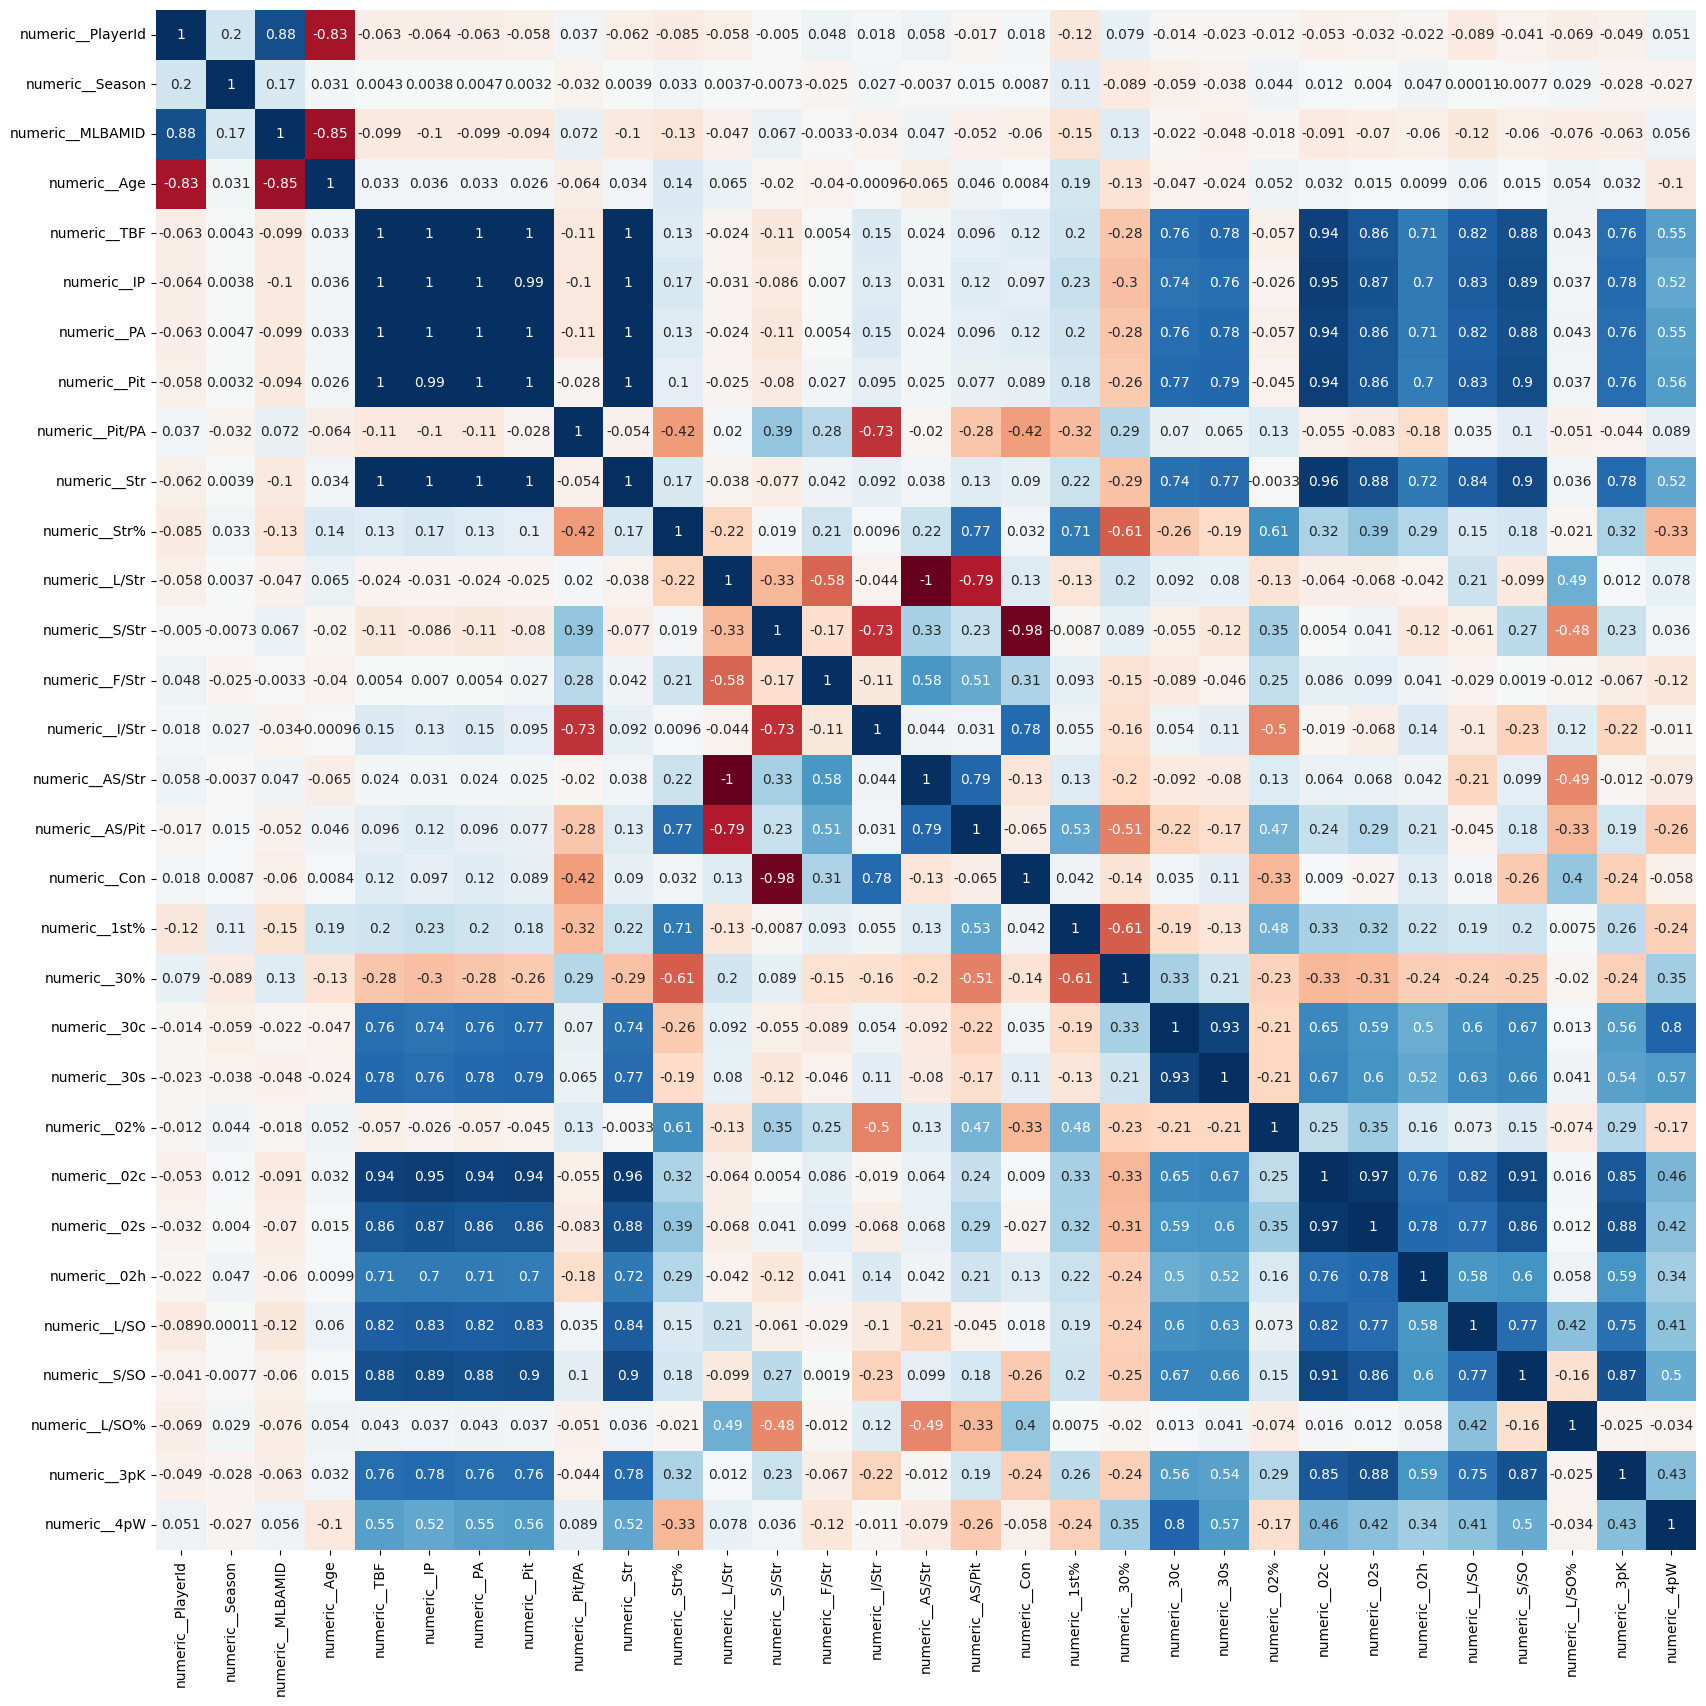

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

_ = sns.heatmap(
    corr.dropna(how="all").dropna(how="all", axis=1),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="RdBu",
    ax=ax,
    cbar=False,
    square=True,
)